<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/13%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_1125_%ED%95%A9%EC%84%B1%EA%B3%B1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 ch4.7

pg. 229~240

#[Chapter 4] 합성곱 신경망(CNN)

# 7. 이미지 분할(Segmentation)

- 이미지 분할 : 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
  - 배경 클래스/객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류됨
  - 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋으로 딥러닝 모델 훈련, 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체 분리 가능
  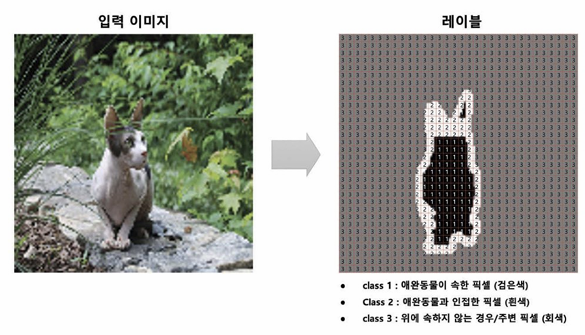

- 이미지 분할
  - 의미 분할(semantic segmentation) : 같은 범주의 여러 객체를 하나의 범주로 묶음
  - 인스턴스 분할(instance segmentation) : 같은 범주에 속하더라도 서로 다른 객체를 구분
  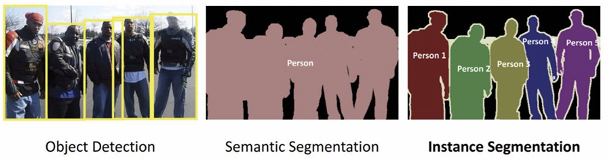

## 7-1. 데이터셋 준비

- Oxford-IIIT Pet Dataset : 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성
  - class 1 : 반려동물이 속한 픽셀(노란색)
  - class 2 : 반려동물과 인접한 픽셀(빨간색)
  - class 3 : 주변 픽셀(파란색)
  
  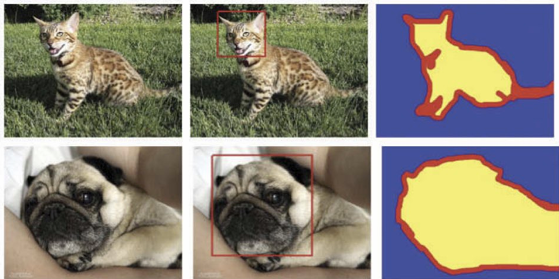

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [3]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [4]:
!pip install tensorflow_datasets==4.9.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7


In [4]:
# 텐서플로 데이터셋 로드
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

4.0.0
Using /root/tensorflow_datasets/oxford_iiit_pet/3.2.0 instead.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDCZR59/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDCZR59/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

- 이미지 크기 (128, 128)로 변경
- 0~1 범위로 정규화
- 마스크 : 0,1,2의 정수형 값을 갖도록 1 차감

In [6]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [7]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

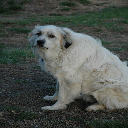

In [8]:
# 샘플 이미지 출력
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

- 255를 곱하여 정규화 이전의 원래 값으로 복원

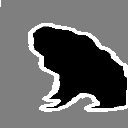

In [9]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

## 7-2. U-Net 모델(인코더-디코더)

- U-Net 모델 : 사전 학습된 VGG16 모델을 인코더로 활용하는 모델
  - VGG16 모델 : 합성곱 층과 풀링 층 직렬로 연결한 구조
  - 인코더 : 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 작은 크기로 축소
  
    -> 마스크 정답을 활용해 각 픽셀의 마스크 범주를 0,1,2 중 하나로 분류하는 역할

In [10]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


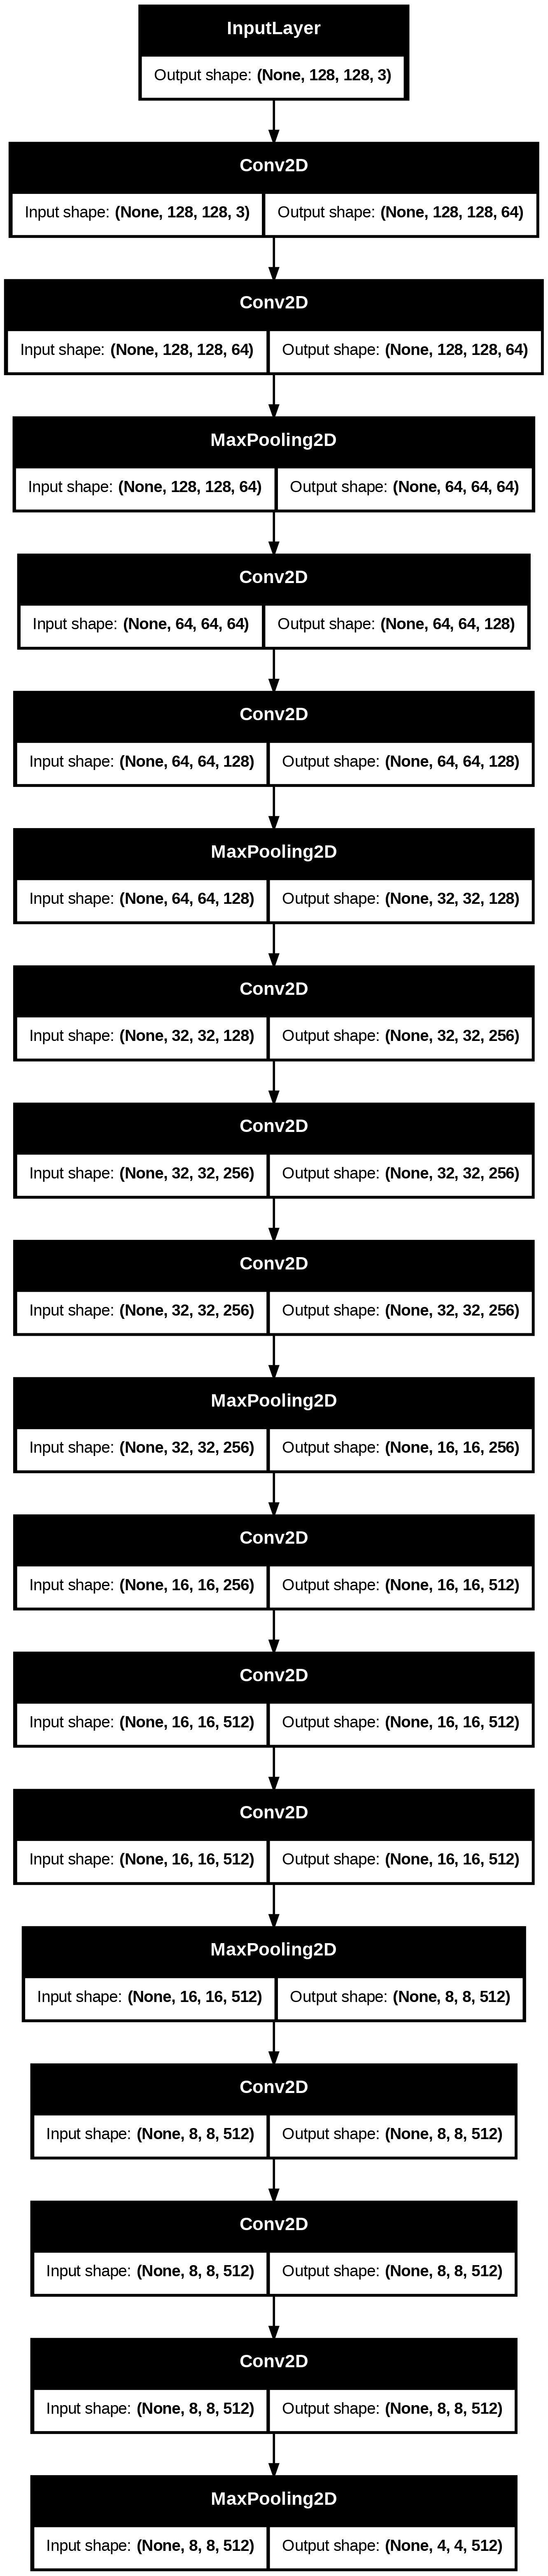

In [11]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

### U-Net 모델 정의

In [12]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

- 사전 학습된 파라미터를 인코더에 그대로 사용
- 업데이트되지 않도록 파라미터 고정

In [13]:
# 파라미터 고정
f_model.trainable = False

In [14]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

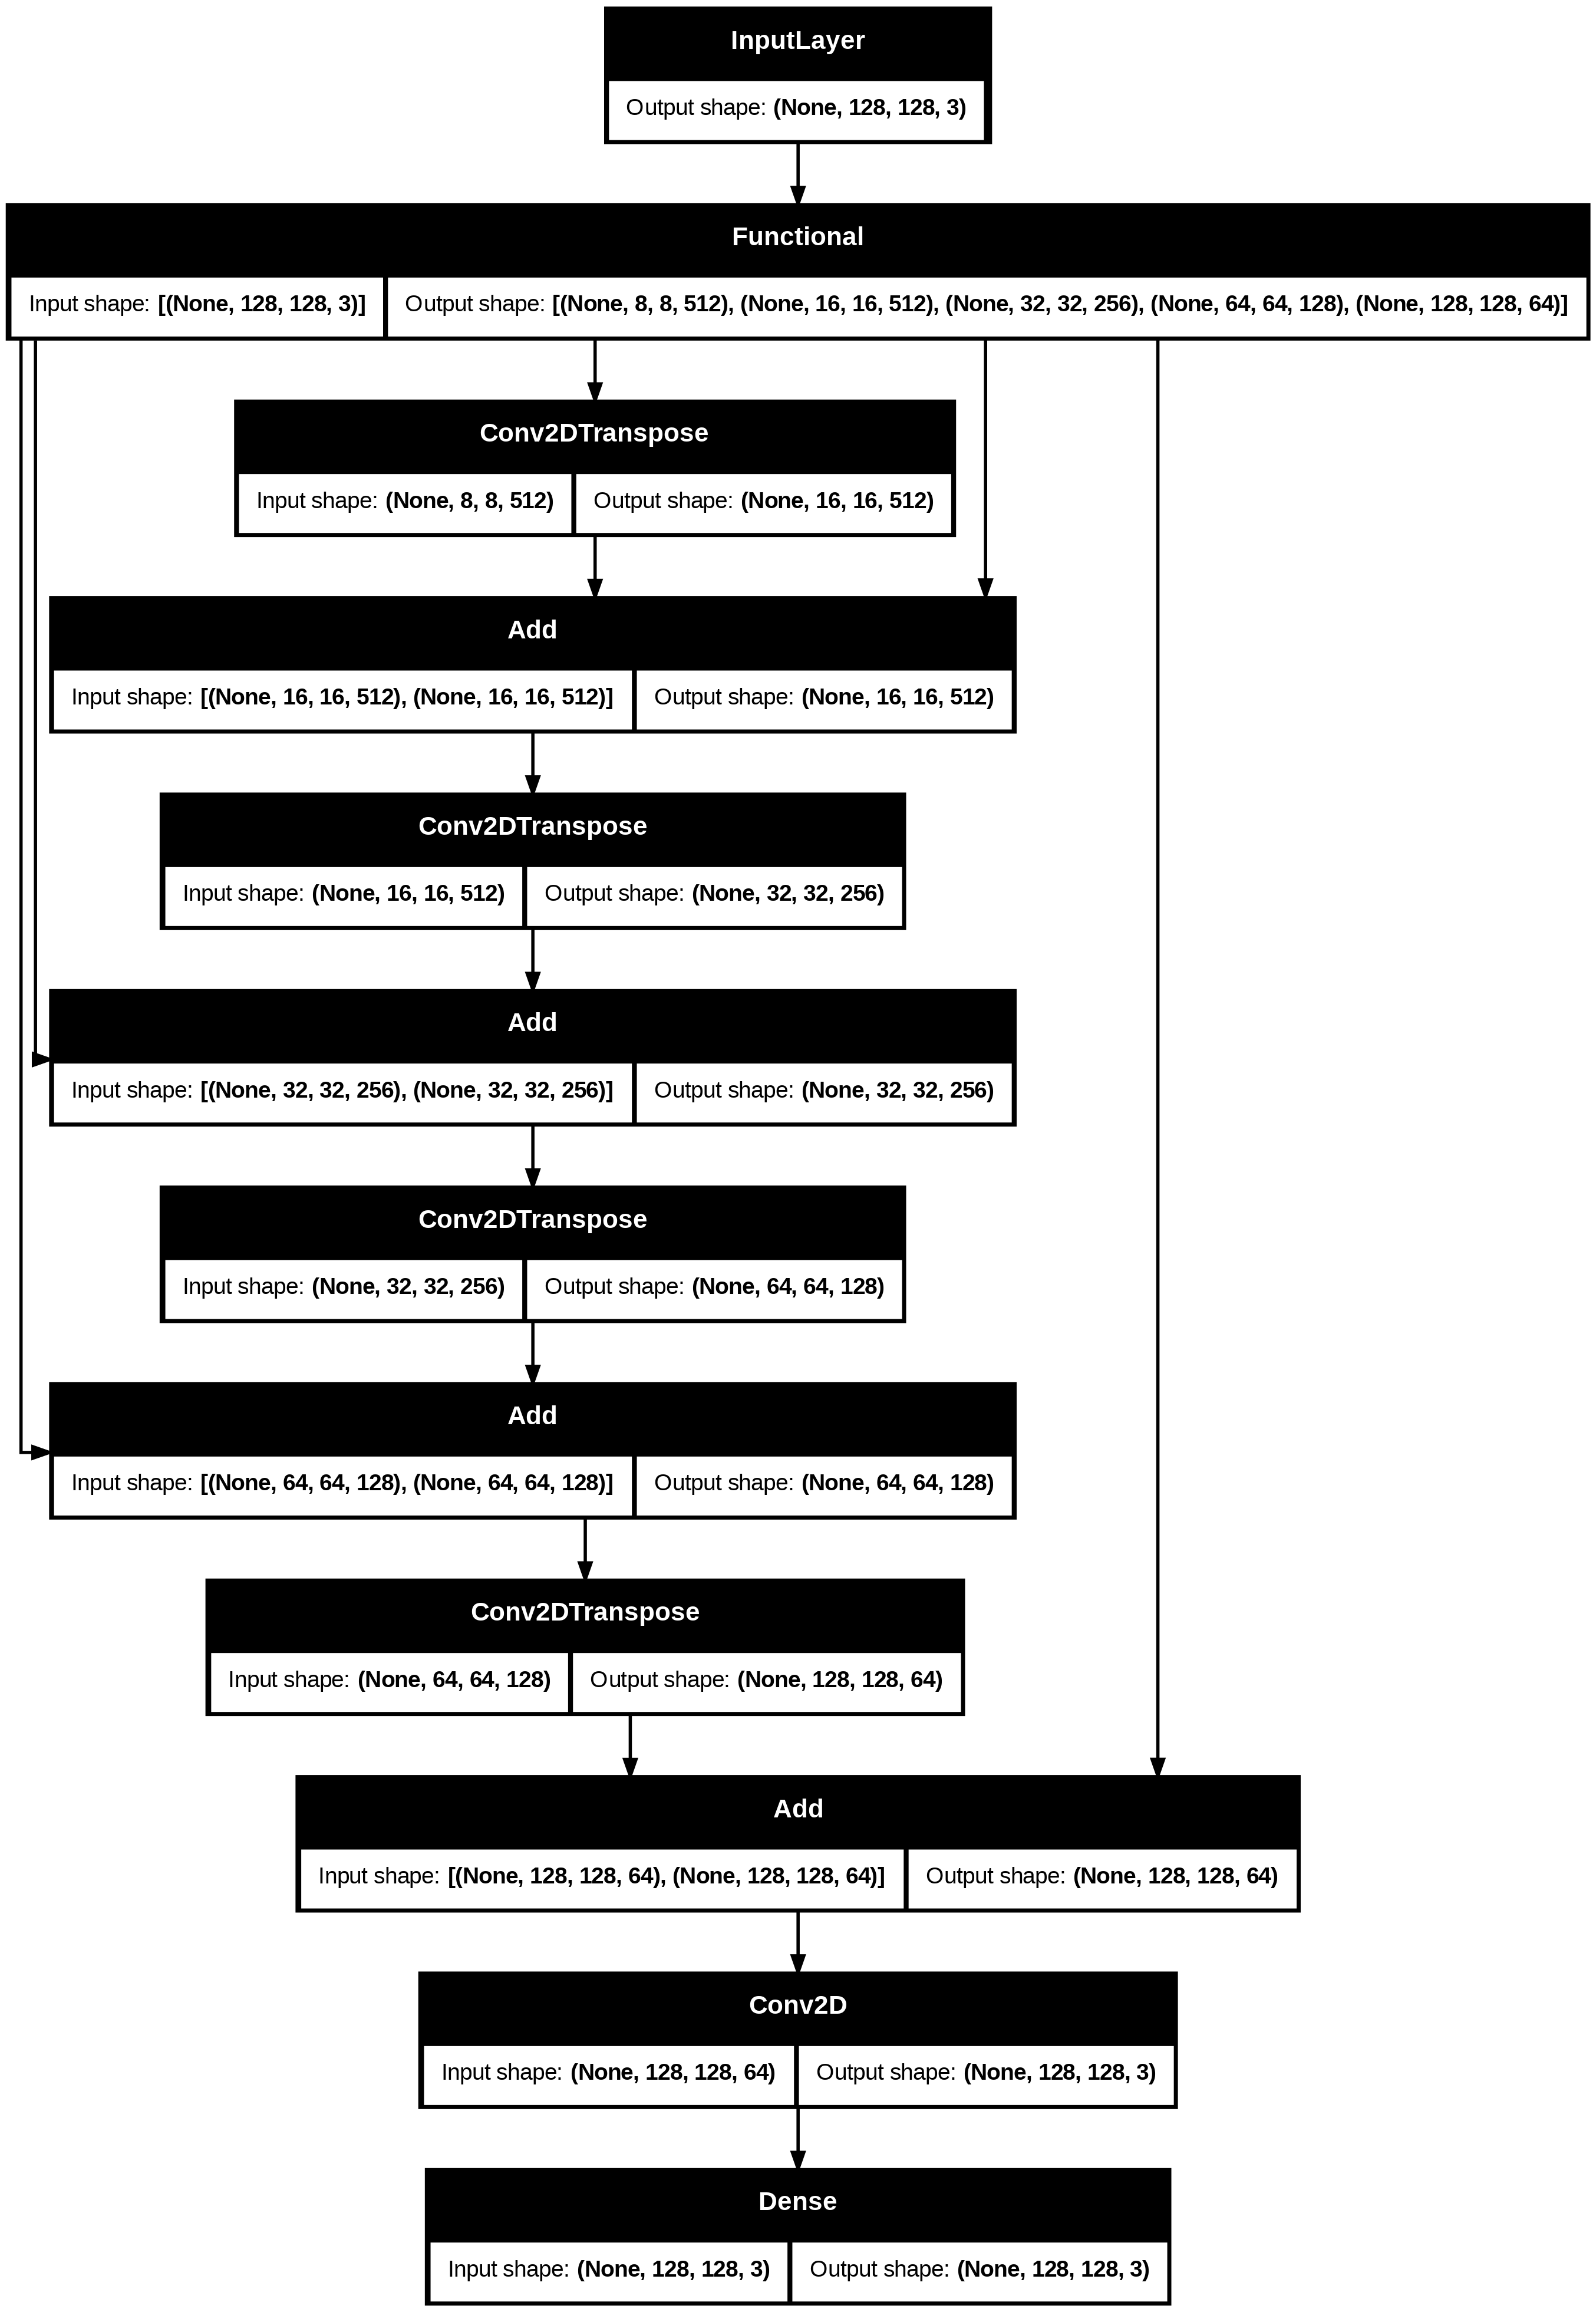

In [15]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [16]:
# 모델 요약
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 8, 8, 512),    │     14,714,688 │ input_layer_1[0][0]    │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 32, 32, 256),   │                │                        │
│                           │ (None, 64, 64, 128),   │                │                        │
│                           │ (None, 128, 128, 64)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,359,808 │ functional[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 256)    │      1,179,904 │ add[0][0]              │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 256)    │              0 │ conv2d_transpose_1[0]… │
│                           │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        295,040 │ add_1[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64, 128)    │              0 │ conv2d_transpose_2[0]… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 64)   │         73,792 │ add_2[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 128, 128, 64)   │              0 │ conv2d_transpose_3[0]… │
│                           │                        │                │ functional[0][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 3)    │          1,731 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 128, 3)    │             12 │ conv2d[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,624,975 (71.05 MB)

 Trainable params: 3,910,287 (14.92 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.6555 - loss: 0.9474
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8164 - loss: 0.5039
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.8238 - loss: 0.4828
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8255 - loss: 0.4754
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.8294 - loss: 0.4666


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


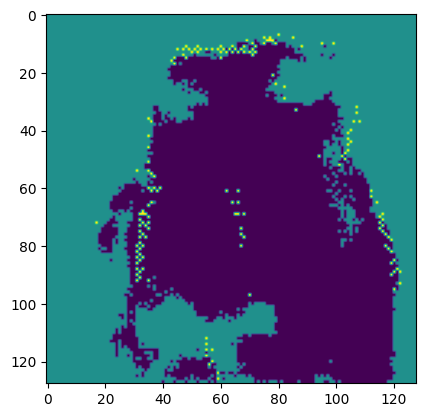

In [18]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

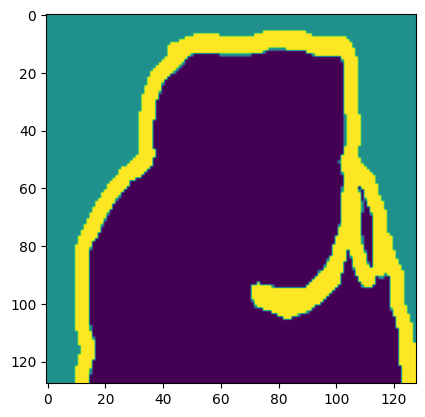

In [19]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))